In [33]:
import json
import gzip
import numpy as np
import string
import random
import operator
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
# from pylmnn.lmnn import LargeMarginNearestNeighbor as LMNN
#from pylmnn.plots import plot_comparison
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

def parseData(file):
    for l in open(file,'r'):
        yield json.loads(l)
        
def remove_punctuation(text):
    return ''.join([c.lower() for c in text if c not in set(string.punctuation)])

np.random.seed(5)

# Data Visualization

In [58]:
data1 = list(parseData('./renttherunway_final_data.json'))

In [59]:
data1[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [60]:
mc_df = pd.read_json('./renttherunway_final_data.json', lines=True)
mc_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [61]:
mc_df.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date'],
      dtype='object')

In [63]:
# mc_df.columns = ['age', 'body_type', 'bust_size', 'category', 'fit', 'height', 'item_id',
#        'rating', 'rented for', 'review_date', 'review_summary', 'review_text',
#        'size', 'user_id', 'weight']
mc_df.columns = ['fit', 'user_id', 'bust_size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body_type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date']

In [64]:
mc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
fit               192544 non-null object
user_id           192544 non-null int64
bust_size         174133 non-null object
item_id           192544 non-null int64
weight            162562 non-null object
rating            192462 non-null float64
rented for        192534 non-null object
review_text       192544 non-null object
body_type         177907 non-null object
review_summary    192544 non-null object
category          192544 non-null object
height            191867 non-null object
size              192544 non-null int64
age               191584 non-null float64
review_date       192544 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [65]:
missing_data = pd.DataFrame({'total_missing': mc_df.isnull().sum(), 'perc_missing': (mc_df.isnull().sum()/192544)*100})
missing_data

,total_missing,perc_missing
fit,0,0.000000
user_id,0,0.000000
bust_size,18411,9.561970
item_id,0,0.000000
weight,29982,15.571506
rating,82,0.042588
rented for,10,0.005194
review_text,0,0.000000
body_type,14637,7.601899
review_summary,0,0.000000


In [9]:
mc_df.describe()

,age,item_id,rating,size,user_id
count,191584.000000,1.925440e+05,192462.000000,192544.000000,192544.000000
mean,33.871017,1.045684e+06,9.092371,12.245175,499494.100149
std,8.058083,8.053148e+05,1.430044,8.494877,289059.719328
min,0.000000,1.233730e+05,2.000000,0.000000,9.000000
25%,29.000000,1.950760e+05,8.000000,8.000000,250654.250000
50%,32.000000,9.483960e+05,10.000000,12.000000,499419.000000
75%,37.000000,1.678888e+06,10.000000,16.000000,750974.000000
max,117.000000,2.966087e+06,10.000000,58.000000,999997.000000


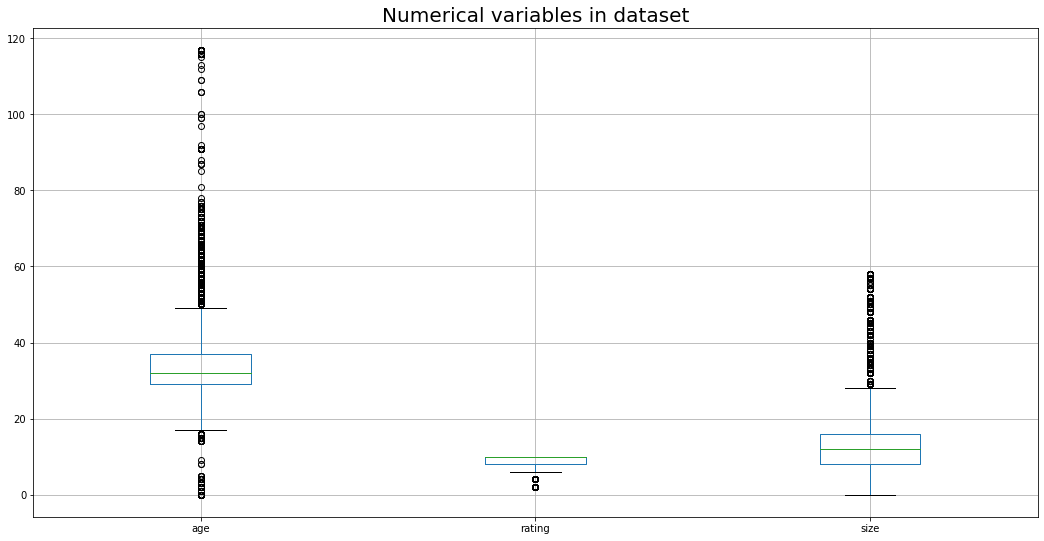

In [10]:
num_cols = ['age','rating','size']
plt.figure(figsize=(18,9))
mc_df[num_cols].boxplot()
plt.title("Numerical variables in dataset", fontsize=20)
plt.show()

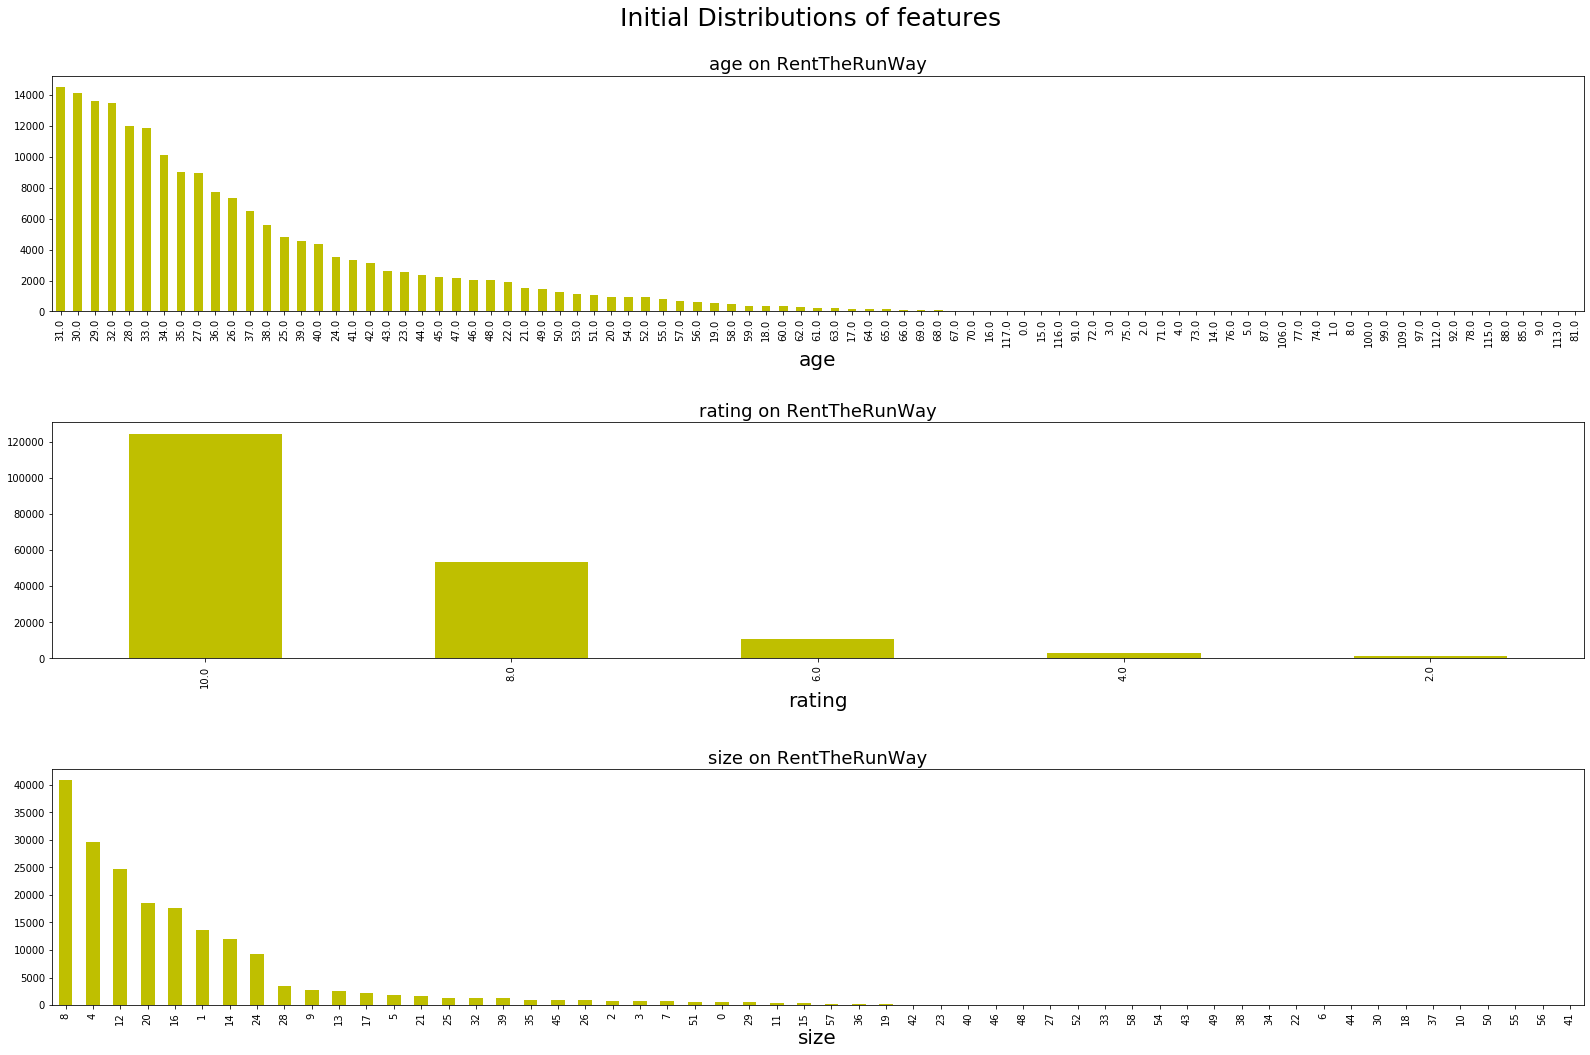

In [63]:
def plot_dist(col, ax):
    mc_df[col][mc_df[col].notnull()].value_counts().plot('bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on RentTheRunWay".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(3,1, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['age','rating','size']
k = 0
for i in range(3):
    plot_dist(cols[k], ax[i])
    k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

In [64]:
def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback - RentTheRunWay {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)
    
def norm_counts(t):
    norms = np.linalg.norm(t.fillna(0), axis=1)
    t_norm = t[0:0]
    for row, euc in zip(t.iterrows(), norms):
        t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
    return t_norm

In [65]:
mc_df.category.value_counts()

dress           92884
gown            44381
sheath          19316
shift            5365
jumpsuit         5184
top              4931
maxi             3443
romper           3070
jacket           2404
mini             1751
skirt            1531
sweater          1149
coat              980
blazer            782
shirtdress        729
blouse            651
down              464
pants             422
vest              278
shirt             277
cardigan          241
frock             205
culottes          188
tank              181
tunic             162
bomber            128
sweatshirt        125
suit              123
leggings          112
pant              107
                ...  
poncho             48
peacoat            39
turtleneck         34
kimono             30
tee                22
trench             20
trousers           18
parka              17
kaftan             17
cami               16
ballgown           16
tight              15
hoodie             14
blouson            14
t-shirt   

- Remark : # category = 68

/Users/sungen/Documents/Jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


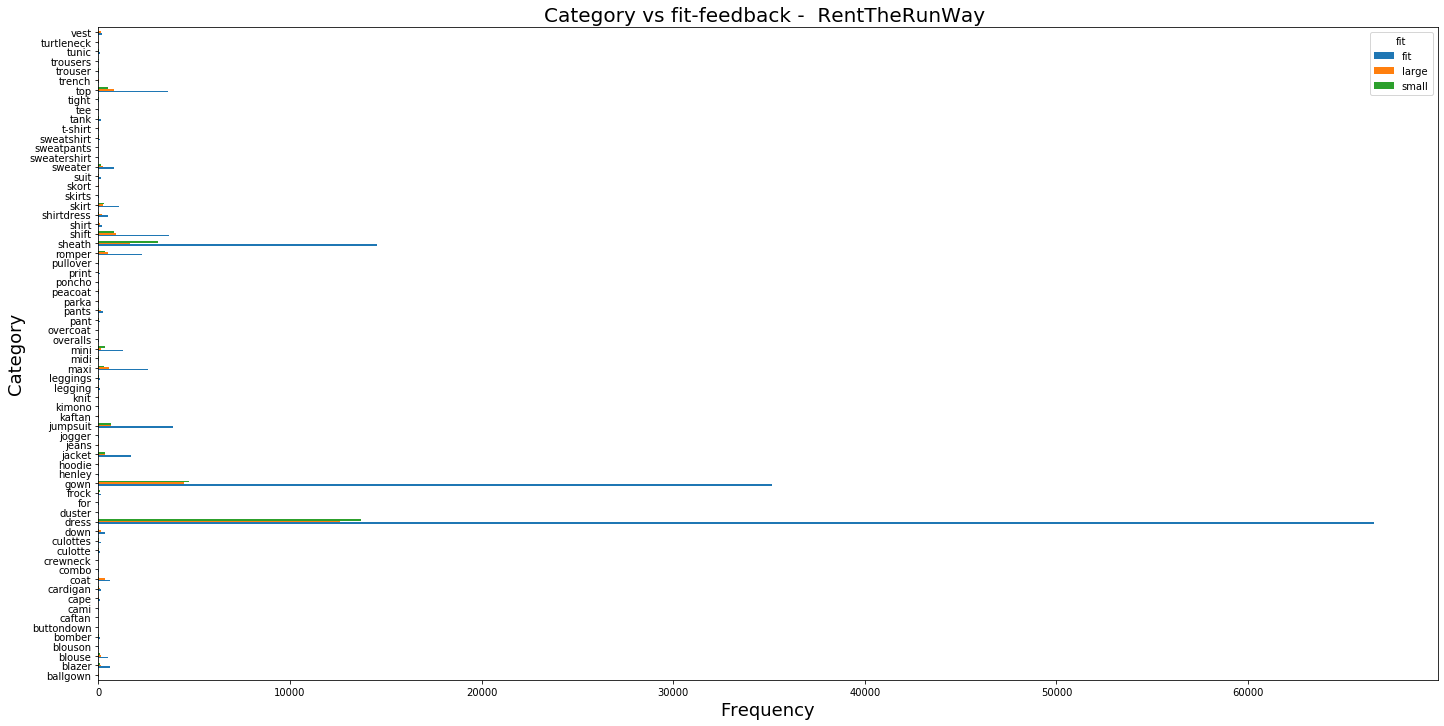

In [66]:
g_by_category = mc_df.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)
plot_barh(cat_fit, 'fit')

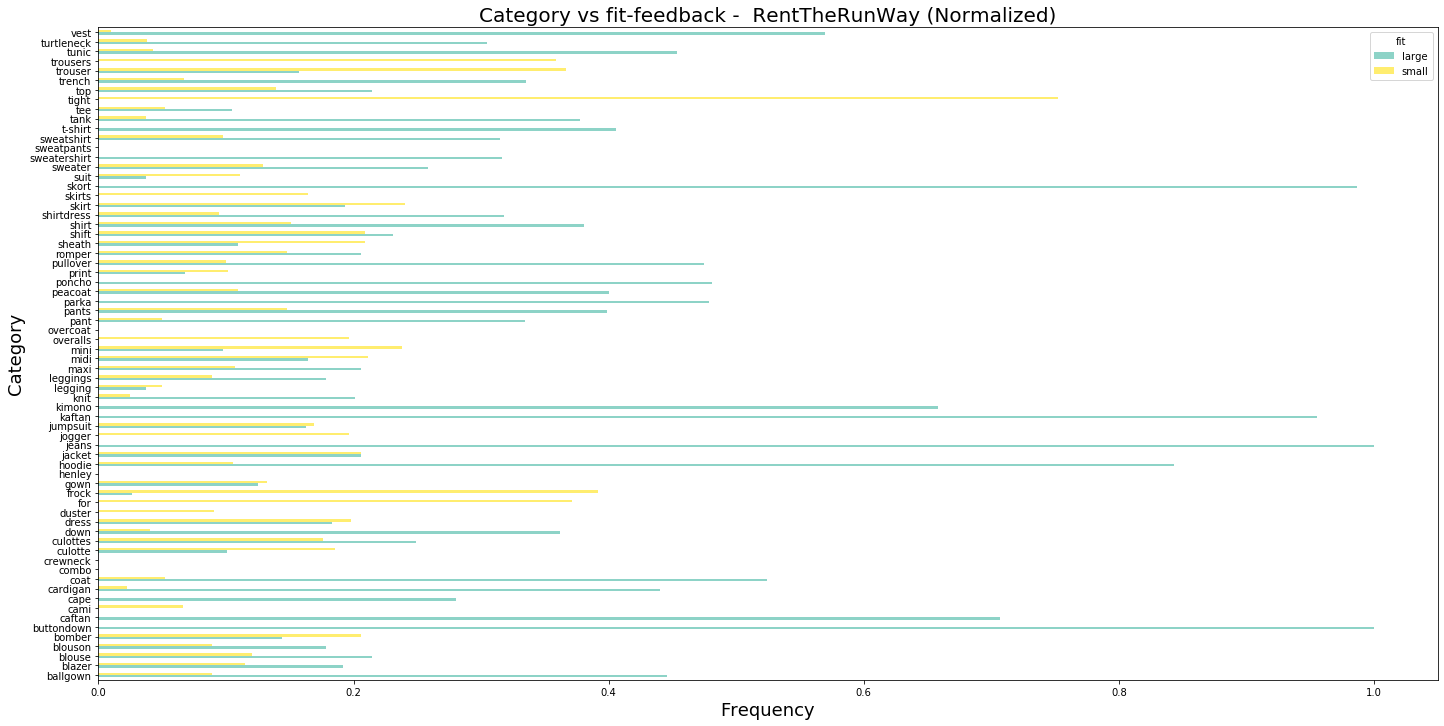

In [67]:
plot_barh(cat_fit_norm, 'fit', norm=1, cmap='Set3')

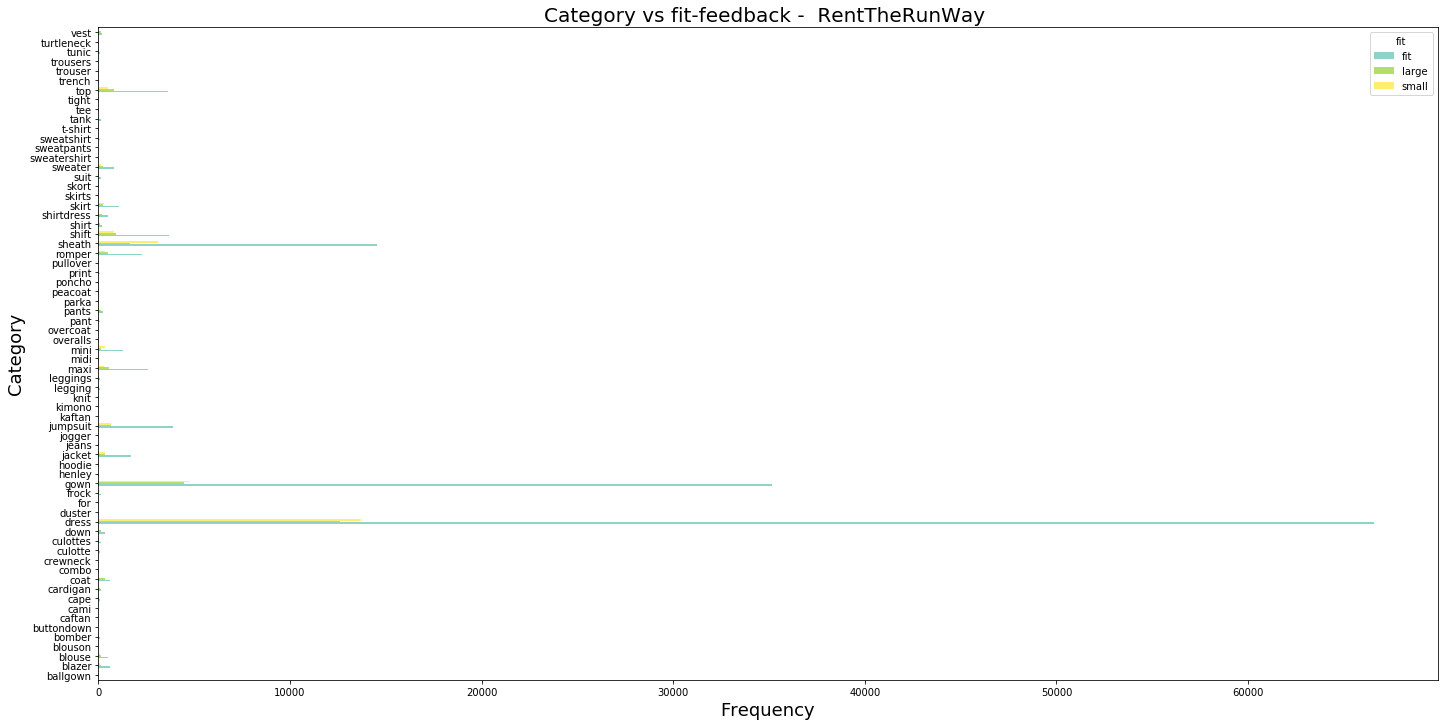

In [70]:
cat_len = g_by_category['fit'].value_counts()
cat_len = cat_len.unstack()
plot_barh(cat_len, 'fit', 'Set3')

/Users/sungen/Documents/Jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


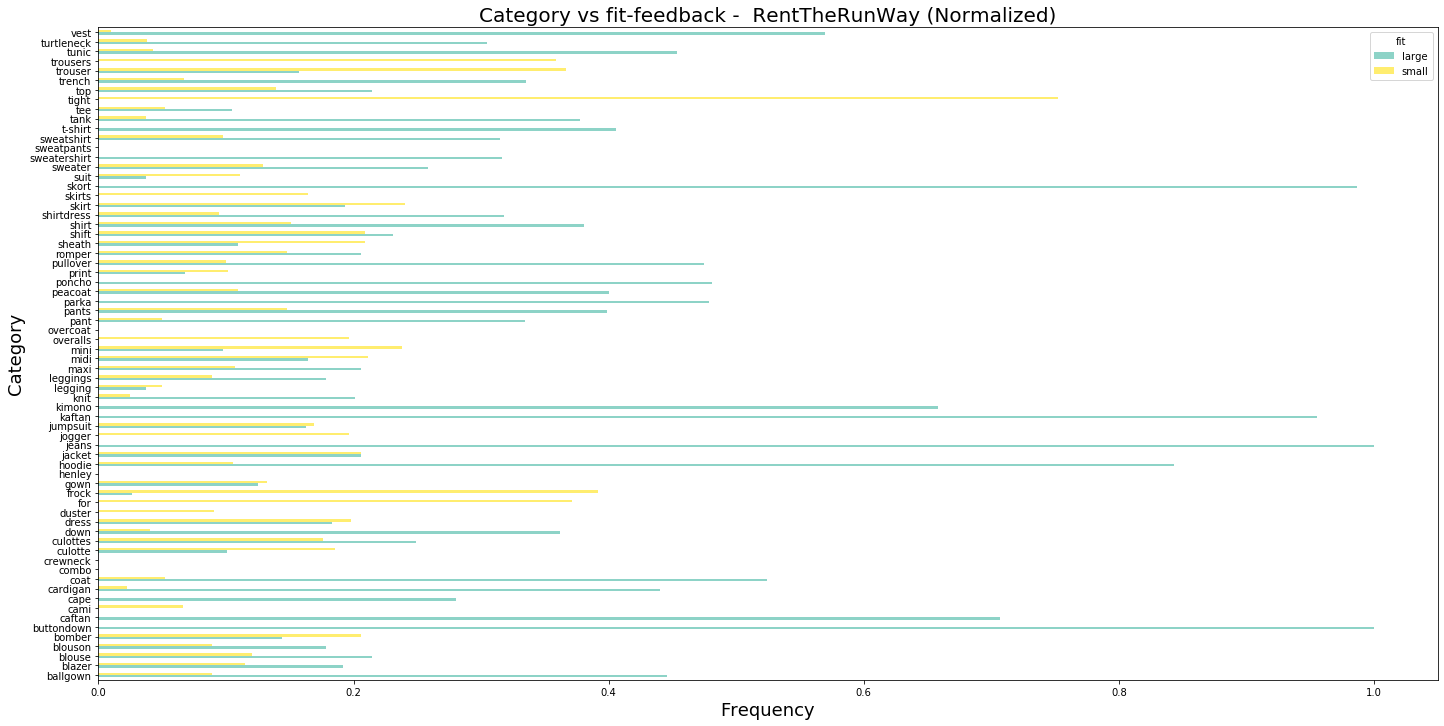

In [73]:
cat_len_norm = norm_counts(cat_len)
cat_len_norm.drop(['fit'], axis = 1, inplace=True)
plot_barh(cat_len_norm, 'fit', cmap='Set3', norm=1)

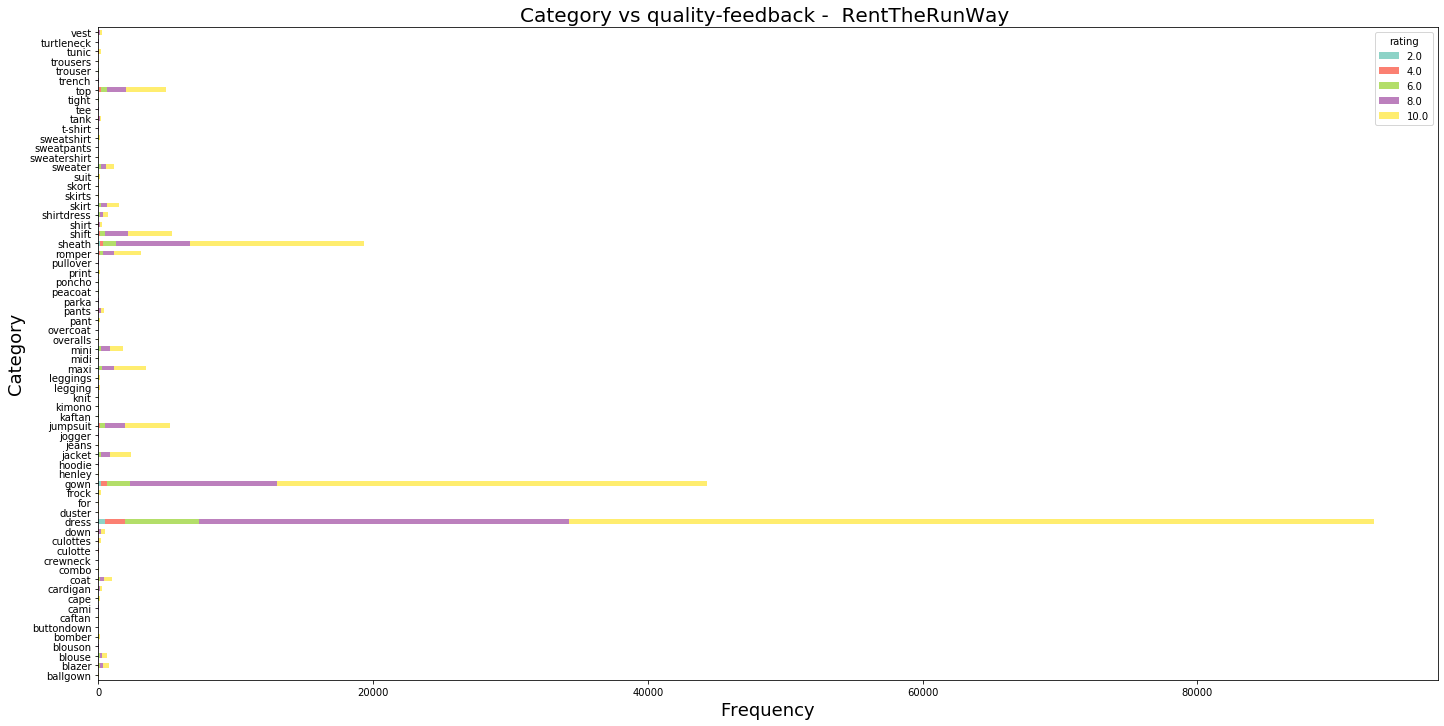

In [74]:
cat_quality = g_by_category['rating'].value_counts()
cat_quality = cat_quality.unstack()
plot_barh(cat_quality, 'quality', 'Set3', stacked=1)

/Users/sungen/Documents/Jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


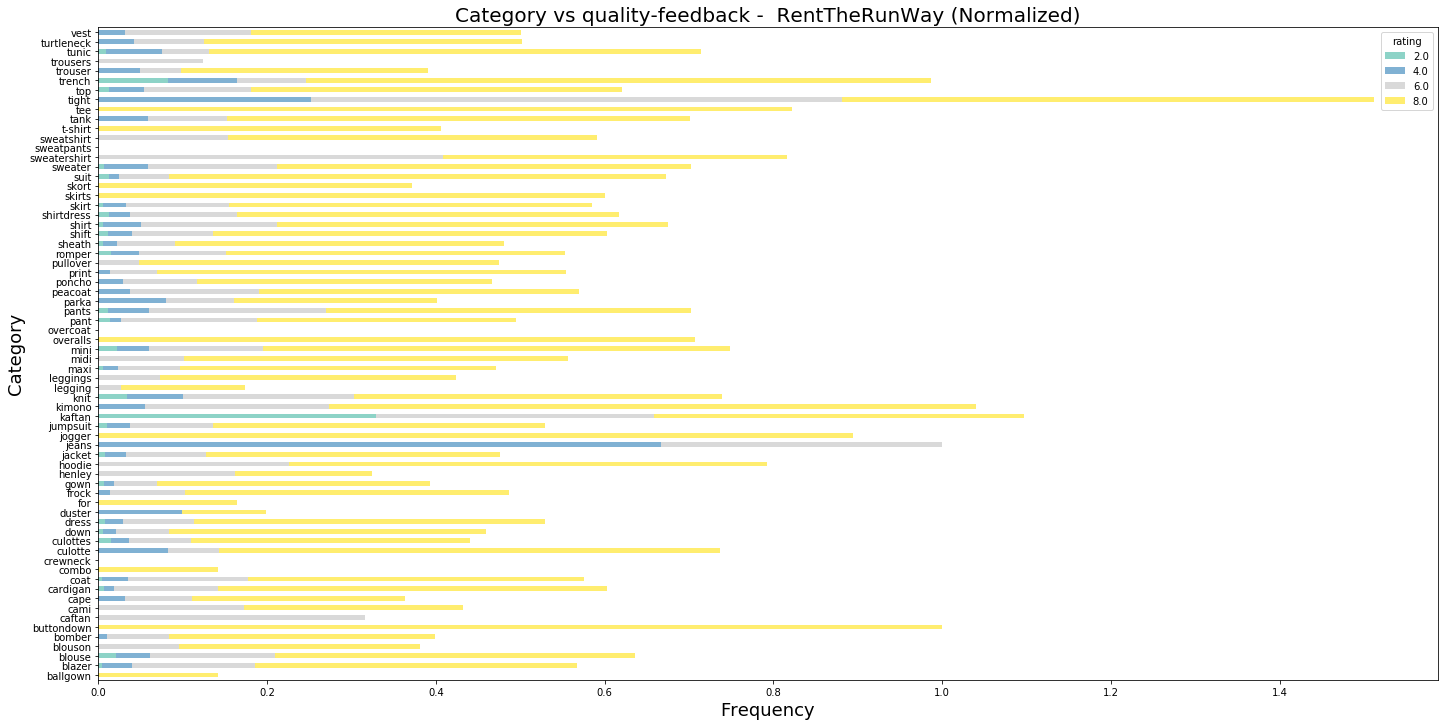

In [78]:
cat_quality_norm = norm_counts(cat_quality)
cat_quality_norm.drop([10.0], axis = 1, inplace=True)
plot_barh(cat_quality_norm, 'quality', 'Set3', stacked=1, norm=1)

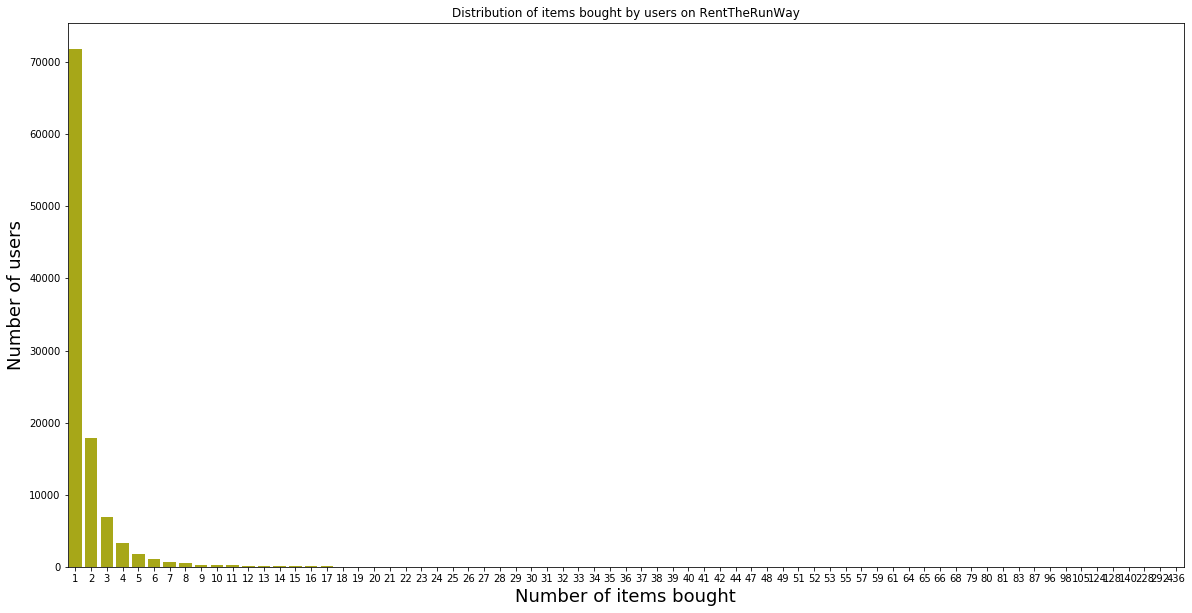

In [81]:
import seaborn as sns
items_bought = []
total_users = []
for i in range(min(mc_df.user_id.value_counts()), max(mc_df.user_id.value_counts())+1):
    all_users = sum(mc_df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on RentTheRunWay")
__ = sns.barplot(x=items_bought, y=total_users, color='y')
fig = plt.gcf()
fig.set_size_inches(20,10)

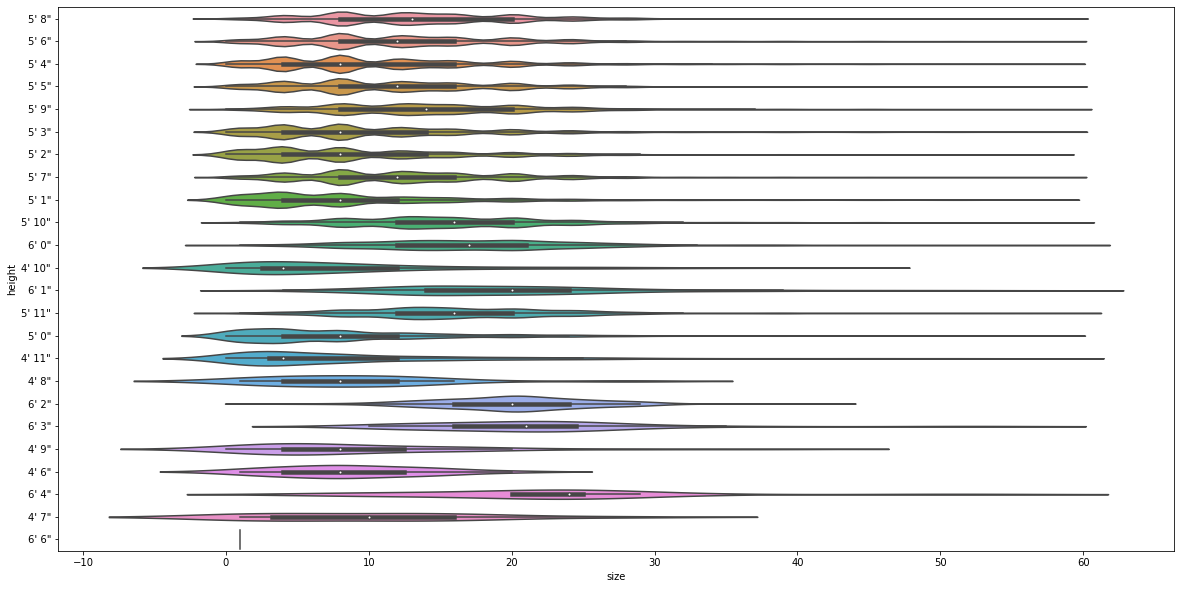

In [82]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(x='size', y='height',data=mc_df, size = 20)

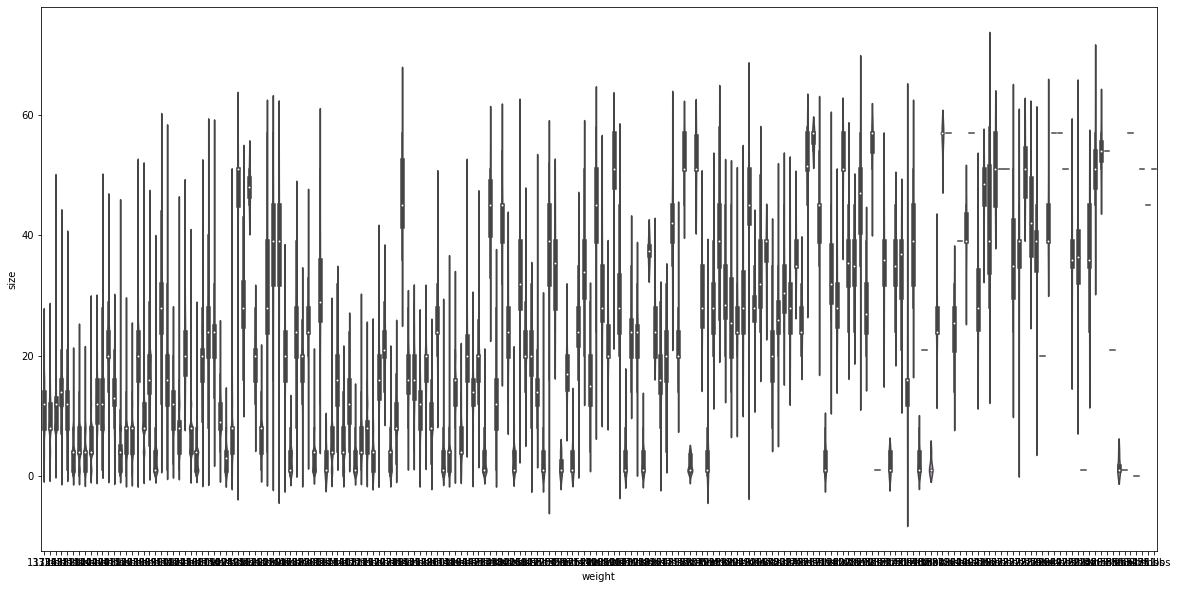

In [84]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(y='size', x='weight',data=mc_df, size = 20)

# Build the dataset

In [66]:
df = mc_df.dropna() # Disregard the missing items
df.shape

(146381, 15)

In [67]:
data = []
for index, row in df.iterrows():
    data.append(row)

In [68]:
data [9]

fit                                                           large
user_id                                                      533900
bust_size                                                       34b
item_id                                                      130259
weight                                                       135lbs
rating                                                            8
rented for                                                  wedding
review_text       This dress was absolutely gorgeous and I recei...
body_type                                                      pear
review_summary    Stunning dress, perfect for a New Year's Eve w...
category                                                      dress
height                                                        5' 6"
size                                                              8
age                                                              30
review_date                                     

* Describe the dataset :

Use “renttherunway_final_data”

Number of customers: 105,508
Number of products: 5,850
Number of transactions: 192,544

Feature Description:
item_id: unique product id
weight: weight measurement of customer
rented for: purpose clothing was rented for
body type: body type of customer
review_text: review given by the customer
review_summary: summary of the review
size: the standardized size of the product
rating: rating for the product
age: age of the customer
category: the category of the product
bust size: bust measurement of customer
height: height of the customer
fit: fit feedback
user_id: a unique id for the customer
review_date: date when the review was written


# Transfer 'height' to numbers in cm

In [69]:
import string
punct = string.punctuation
sum_height = []
for d in data:
    if 'height' not in d:
        continue
    if d['height'] == None:
        continue
    t = d['height']
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    d['height'] = int(words[0]) * 30.48 + int(words[1]) * 2.54
    sum_height.append(d['height'])
ave_hight = sum(sum_height) / len(sum_height)

In [70]:
ave_hight

165.768155293403

# Transfer 'weight' to numbers in lb

In [71]:
sum_weight = []
for d in data:
    if 'weight' not in d:
        continue
    if d['weight'] == None:
        continue
    t = [s for s in d['weight'] if s.isdigit()]
    t = int(''.join(t))
    d['weight'] = t
    sum_weight.append(d['weight'])
ave_weight = sum(sum_weight) / len(sum_weight)
print(ave_weight)

137.20987013341895


# Transfer 'bust size' to numbers

In [72]:
bust = set()
for d in data:
    if 'bust_size' not in d:
        continue
    if d['bust_size'] == None:
        continue
    st = [s for s in d['bust_size'] if not s.isdigit()]
    st = ''.join(st)
    bust.add(st)

In [73]:
bust = list(bust)
bust.sort()
bust

['a', 'aa', 'b', 'c', 'd', 'd+', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']

In [74]:
onehot = {}
for i in range(len(bust)):
    initial = np.zeros(len(bust)+1)
    initial[i+1] = 1
    onehot[bust[i]] = initial

In [75]:
onehot

{'a': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'aa': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'b': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'c': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'd': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'd+': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'dd': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'ddd/e': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'f': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'g': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'h': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'i': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'j': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [76]:
for d in data:
    t = [s for s in d['bust_size'] if s.isdigit()]
    t = int(''.join(t))
    st = [s for s in d['bust_size'] if not s.isdigit()]
    st = ''.join(st)
    onehot[st][0]= t
    d['bust_size'] = onehot[st]

In [77]:
data[4]

fit                                                             fit
user_id                                                      734848
bust_size         [36.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
item_id                                                      364092
weight                                                          138
rating                                                            8
rented for                                                     date
review_text       Didn't actually wear it. It fit perfectly. The...
body_type                                                  athletic
review_summary                      Traditional with a touch a sass
category                                                      dress
height                                                       172.72
size                                                              8
age                                                              45
review_date                                     

In [78]:
random.seed(1)
random.shuffle(data)

train_data = data[:int(0.8*len(data))]
val_data = data[int(0.8*len(data)):int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]

len(data), len(train_data), len(val_data), len(test_data)

(146381, 117104, 14638, 14639)

# Rating distribution

In [32]:
num_star=[]
for i in range(11):
    numofstar = [int(d['rating']) == i for d in data if d['rating'] != None]
    num_star.append(sum(numofstar))
print(num_star)
print(sum(num_star))

[0, 0, 783, 0, 2205, 0, 8341, 0, 40761, 0, 94291]
146381


<BarContainer object of 11 artists>

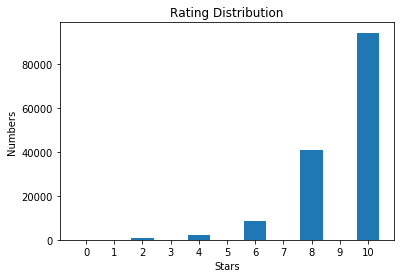

In [33]:
from matplotlib import pyplot as plt
X = [0,1,2,3,4,5,6,7,8,9,10]
Y = num_star
plt.xlabel("Stars")
plt.ylabel("Numbers")
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],['0','1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.title("Rating Distribution")
plt.bar(X, Y)

In [34]:
nRatings = sum(num_star)

In [35]:
average = 0
for d in data:
    if d['rating'] != None:
        average += int(d['rating'])
average /= nRatings
print(average)

9.081984683804592


Remark： Highly imbalanced data. Most of the rating is fullmark (10 Point)

# Users and items distribution

In [79]:
item_data = {}
item_index = {}
user_index = {}
user_data = {}
u_index = 0
i_index = 0
for r in train_data:
    if str(r['item_id']) + '|' + str(r['size']) not in item_data:
        item_data[str(r['item_id']) + '|' + str(r['size'])] = [r]
        item_index[str(r['item_id']) + '|' + str(r['size'])] = i_index
        i_index += 1
    else:
        item_data[str(r['item_id']) + '|' + str(r['size'])].append(r)
        
    if r['user_id'] not in user_data:
        user_data[r['user_id']] = [r]
        user_index[r['user_id']] = u_index
        u_index += 1
    else:
        user_data[r['user_id']].append(r)

In [80]:
len(user_data), len(user_index), len(item_data), len(item_index)

(66495, 66495, 26198, 26198)

# Size Prediction

In [123]:
def feature(dataset):
    feat = [1]
    feat.append(dataset['height'])
    feat.append(dataset['weight'])
    feat = feat + list(dataset['bust_size'])
    return feat

In [124]:
X_train = [feature(d) for d in train_data]
X_valid = [feature(d) for d in val_data]
y_train = [d['size'] for d in train_data]
y_valid = [d['size'] for d in val_data]

In [125]:
X_train[:2]

[[1,
  165.1,
  120,
  34.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1,
  162.56,
  115,
  36.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

In [84]:
y_train[:10]

[4, 4, 24, 4, 8, 1, 4, 8, 12, 4]

In [54]:
theta,residuals,rank,s = np.linalg.lstsq(X_train, y_train)
print(theta)

[-0.25687313 -0.11252349  0.31507325 -0.34904429 -1.0649248  -1.33835048
 -0.73047006 -0.24484903 -0.55436659  1.16470627 -0.68631815 -0.5062719
 -0.65753225 -1.46811342  2.45081446  1.41938696  1.95941587]


/Users/sungen/Documents/Jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [114]:
import sklearn.metrics as sm

In [56]:
theta_Mat = np.matrix(theta)
X_train_Mat = np.matrix(X_train)
y_train_Mat = np.matrix(y_train)
X_valid_Mat = np.matrix(X_valid)
y_valid_Mat = np.matrix(y_valid)

In [57]:
y_train_pred = np.dot(theta_Mat, X_train_Mat.T)
MSE_train = sm.mean_squared_error(y_train_Mat, y_train_pred)
print('MSE_train =', MSE_train)

MSE_train = 16.697021350775483


In [58]:
y_valid_pred = np.dot(theta_Mat, X_valid_Mat.T)
MSE_test = sm.mean_squared_error(y_valid_Mat, y_valid_pred)
print('MSE_test =', MSE_test)

MSE_test = 16.816549710259217


Because different catagories have different size ranges, so we should do the regression based on the catagory. 

# Predict 'Fit'

## Assign id for each category

In [89]:
category_count = defaultdict(int)
total_categories = 0
for d in data:
    if 'category' not in d:
        continue
    c = d['category']
    total_categories += 1
    category_count[c] += 1
counts = [(category_count[c], c) for c in category_count]
counts.sort()
counts.reverse()
categories = [c[1] for c in counts]
category_id = dict(zip(categories, range(len(categories))))
category_set = set(categories)

In [90]:
counts[:10]

[(70474, 'dress'),
 (33278, 'gown'),
 (14691, 'sheath'),
 (4039, 'shift'),
 (4019, 'jumpsuit'),
 (3780, 'top'),
 (2600, 'maxi'),
 (2447, 'romper'),
 (1871, 'jacket'),
 (1417, 'mini')]

In [91]:
category_id['dress']

0

In [161]:
from sklearn.linear_model import LogisticRegression

def train(data, c): # predict given a specific category
    try:
        random.seed(1)
        random.shuffle(data)

        train_data = data[:int(0.8*len(data))]
        val_data = data[int(0.8*len(data)):int(0.9*len(data))]
        test_data = data[int(0.9*len(data)):]

        len(data), len(train_data), len(val_data), len(test_data)

        X_train = [feature(d) for d in train_data]
        X_valid = [feature(d) for d in val_data]
        y_train = [d['size'] for d in train_data]
        y_valid = [d['size'] for d in val_data]

        clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
        theta = clf.coef_

        y_train_pred = clf.predict(X_train)
        MSE_train = sm.mean_squared_error(y_train, y_train_pred)

        y_valid_pred = clf.predict(X_valid)
        MSE_test = sm.mean_squared_error(y_valid, y_valid_pred)

        return {
            'category': c,
    #         'theta': theta,
            'clf': clf,
            'MSE_train': MSE_train, 
            'MSE_test': MSE_test,
        }
    except ValueError:
        print(c)
        print(len(data))

## train regressor for each category 

In [168]:
data_c = {}
data_train = data[:int(0.9*len(data))]
for d in data[:int(len(data_train))]:
    if d['fit'] != 'fit':
        continue
    c = d['category']
    if c not in data_c:
        data_c[c] = []
    data_c[c].append(d)


In [169]:
# train(data_c['dress'], 'dress')
clfs = {}
for c in categories:
    if c in data_c and len(data_c[c]) > 0:
        clfs[c] = train(data_c[c], c)

/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

kaftan
3


/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/czf/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


hoodie
5
overalls
5
for
4
skirts
4
jogger
3
caftan
2
sweatershirt
2
overcoat
1
crewneck
1


In [170]:
for c in clfs:
    print(c + " ", clfs[c]['MSE_test'])

dress  18.209353628943305
gown  18.094196804037004
sheath  20.300200803212853
shift  23.253061224489795
jumpsuit  16.917293233082706
top  14.876
maxi  18.53370786516854
romper  12.896969696969697
jacket  10.606837606837606
mini  9.242105263157894
skirt  17.094594594594593
sweater  12.271186440677965
coat  19.146341463414632
blazer  13.162790697674419
shirtdress  24.805555555555557
blouse  17.727272727272727
down  13.333333333333334
pants  14.368421052631579
vest  34.18181818181818
shirt  18.416666666666668
cardigan  15.0
frock  2.7
culottes  27.6
tank  64.5
tunic  28.142857142857142
suit  5.125
bomber  21.714285714285715
sweatshirt  20.0
leggings  23.333333333333332
print  17.714285714285715
legging  12.0
pant  21.6
cape  6.75
culotte  15.25
trouser  29.666666666666668
pullover  17.333333333333332
midi  33.333333333333336
knit  18.0
poncho  68.0
peacoat  32.5
kimono  100.0
turtleneck  18.0
trench  0.0
tee  36.0
tight  0.0
parka  16.0


TypeError: 'NoneType' object is not subscriptable

## Using size and pred to get fit

In [178]:
data_dev = data[int(len(data) * 0.9):]
y_dev = [d['fit'] for d in data_dev]
pred = []
for d in data_dev:
    res = 'fit'
    c = d['category']
    if c in clfs and clfs[c] is not None:
        clf = clfs[c]['clf']
        y = clf.predict([feature(d)])
        if y > d['size'] + 10:
            res = 'large'
        elif y < d['size'] - 10:
            res = 'small'
    pred.append(res)
        

In [179]:
pred[:10], y_dev[:10]

(['fit', 'fit', 'fit', 'fit', 'fit', 'fit', 'fit', 'small', 'fit', 'fit'],
 ['fit', 'fit', 'fit', 'fit', 'fit', 'fit', 'fit', 'fit', 'small', 'fit'])

In [180]:
def evaluate(y, pred):
    t_fit, f_fit, t_small, f_small, t_large, f_large = 0, 0, 0, 0, 0, 0
    correct = 0
    tot, tot_fit, tot_small, tot_large = len(y), 0, 0, 0
    
    for i in range(0, tot):
        if pred[i] == y[i]:
            correct += 1
        if pred[i] == 'fit': #fit
            if y[i] == pred[i]: t_fit += 1
            else: f_fit += 1
            tot_fit += 1
        elif pred[i] == 'small': #small
            if y[i] == pred[i]: t_small += 1
            else: f_small += 1
            tot_small += 1
        else:
            if y[i] == pred[i]: t_large += 1
            else: f_large += 1
            tot_large += 1
    
    precision_fit = t_fit / (t_fit + f_fit)
    precision_small = t_small / (t_small + f_small)
    precision_lager = t_large / (t_large + f_large)
    
    recall_fit = t_fit / tot_fit
    recall_small = t_small / tot_small
    recall_large = t_large / tot_large
    
    acc = correct / tot
    
    return {
        'acc': acc,
        'precision_fit': precision_fit, 
        'precision_small': precision_small, 
        'precision_lager': precision_lager, 
        'recall_fit': recall_fit, 
        'recall_small': recall_small, 
        'recall_large': recall_large, 
    }

In [181]:
evaluate(y_dev, pred)

{'acc': 0.7186283216066671,
 'precision_fit': 0.7333474606201879,
 'precision_small': 0.2808022922636103,
 'precision_lager': 0.3007518796992481,
 'recall_fit': 0.7333474606201879,
 'recall_small': 0.2808022922636103,
 'recall_large': 0.3007518796992481}

# Ignore the following part

In [102]:
X_train[0]

[1,
 165.1,
 120,
 34.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [107]:
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.neighbors import KNeighborsRegressor

In [108]:
knn = KNeighborsRegressor()
multiOutputRegressor = MultiOutputRegressor(knn)

In [109]:
multiOutputRegressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform'),
                     n_jobs=None)

In [110]:
pred = multiOutputRegressor.predict(X_dev)

In [118]:
def cal_MSE(pred, y, data):
    l1 = []
    l2 = []
    for i in range(0, len(data)):
        c = data[i]['category']
        c_id = category_id[c]
        l1.append(pred[i][c_id])
        l2.append(y[i][c_id])
    ret = sm.mean_squared_error(l1, l2)
    return ret

In [119]:
cal_MSE(pred, y_dev, val_data)

110.79968028419184

In [122]:
multiOutputRegressor.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'n_jobs': None}